# Análisis de datos médicos con aprendizaje no supervisado

Getzemani Kinari Ríos Tavares A00573866

Valeria Aguilar Meza A01741304

In [110]:
# Download necessary libraries
!pip install statsmodels
!pip install seaborn

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
from scipy import stats
import seaborn as sns

# clustering methods
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN

from scipy.cluster.hierarchy import dendrogram, linkage

# Metrics for evaluating clustering results
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# Distance metrics
from sklearn.metrics import pairwise_distances

Dataset from Kaggle de Salud Mental

In [132]:
data = pd.read_csv("mental_illnesses.csv")

In [134]:
data.head()

,Entity,Code,Year,Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized,Depressive disorders (share of population) - Sex: Both - Age: Age-standardized,Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized,Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized,Eating disorders (share of population) - Sex: Both - Age: Age-standardized
0,Afghanistan,AFG,1990,0.223206,4.996118,4.713314,0.703023,0.127700
1,Afghanistan,AFG,1991,0.222454,4.989290,4.702100,0.702069,0.123256
2,Afghanistan,AFG,1992,0.221751,4.981346,4.683743,0.700792,0.118844
3,Afghanistan,AFG,1993,0.220987,4.976958,4.673549,0.700087,0.115089
4,Afghanistan,AFG,1994,0.220183,4.977782,4.670810,0.699898,0.111815


In [136]:
df = pd.DataFrame(data)

In [138]:
def describe(df):
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        
    output = pd.DataFrame({
        'variable': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing value': missing
    })    
        
    return output

In [140]:
df.describe

<bound method NDFrame.describe of            Entity Code  Year  \
0     Afghanistan  AFG  1990   
1     Afghanistan  AFG  1991   
2     Afghanistan  AFG  1992   
3     Afghanistan  AFG  1993   
4     Afghanistan  AFG  1994   
...           ...  ...   ...   
6415     Zimbabwe  ZWE  2015   
6416     Zimbabwe  ZWE  2016   
6417     Zimbabwe  ZWE  2017   
6418     Zimbabwe  ZWE  2018   
6419     Zimbabwe  ZWE  2019   

      Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized  \
0                                              0.223206                                   
1                                              0.222454                                   
2                                              0.221751                                   
3                                              0.220987                                   
4                                              0.220183                                   
...                                

In [142]:
df = df.rename(columns={'Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized': 'Schizophrenia', 
                          'Depressive disorders (share of population) - Sex: Both - Age: Age-standardized': 'Depressive',
                         'Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized':'Anxiety',
                         'Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized':'Bipolar',
                         'Eating disorders (share of population) - Sex: Both - Age: Age-standardized':'Eating'})

In [144]:
df

,Entity,Code,Year,Schizophrenia,Depressive,Anxiety,Bipolar,Eating
0,Afghanistan,AFG,1990,0.223206,4.996118,4.713314,0.703023,0.127700
1,Afghanistan,AFG,1991,0.222454,4.989290,4.702100,0.702069,0.123256
2,Afghanistan,AFG,1992,0.221751,4.981346,4.683743,0.700792,0.118844
3,Afghanistan,AFG,1993,0.220987,4.976958,4.673549,0.700087,0.115089
4,Afghanistan,AFG,1994,0.220183,4.977782,4.670810,0.699898,0.111815
...,...,...,...,...,...,...,...,...
6415,Zimbabwe,ZWE,2015,0.201042,3.407624,3.184012,0.538596,0.095652
6416,Zimbabwe,ZWE,2016,0.201319,3.410755,3.187148,0.538593,0.096662
6417,Zimbabwe,ZWE,2017,0.201639,3.411965,3.188418,0.538589,0.097330
6418,Zimbabwe,ZWE,2018,0.201976,3.406929,3.172111,0.538585,0.097909


Feature Selection:
En este dataset, usamos 5 variables: Schizophrenia, Depressive, Anxiety, Bipolar and Eating

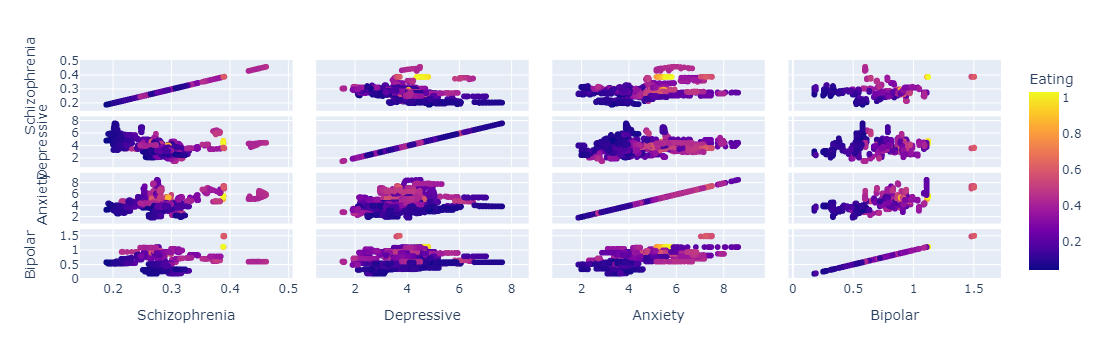

In [148]:
fig = px.scatter_matrix(df, dimensions=["Schizophrenia", "Depressive", "Anxiety", "Bipolar"], color="Eating")
fig.show()

Heatmap

<Axes: >

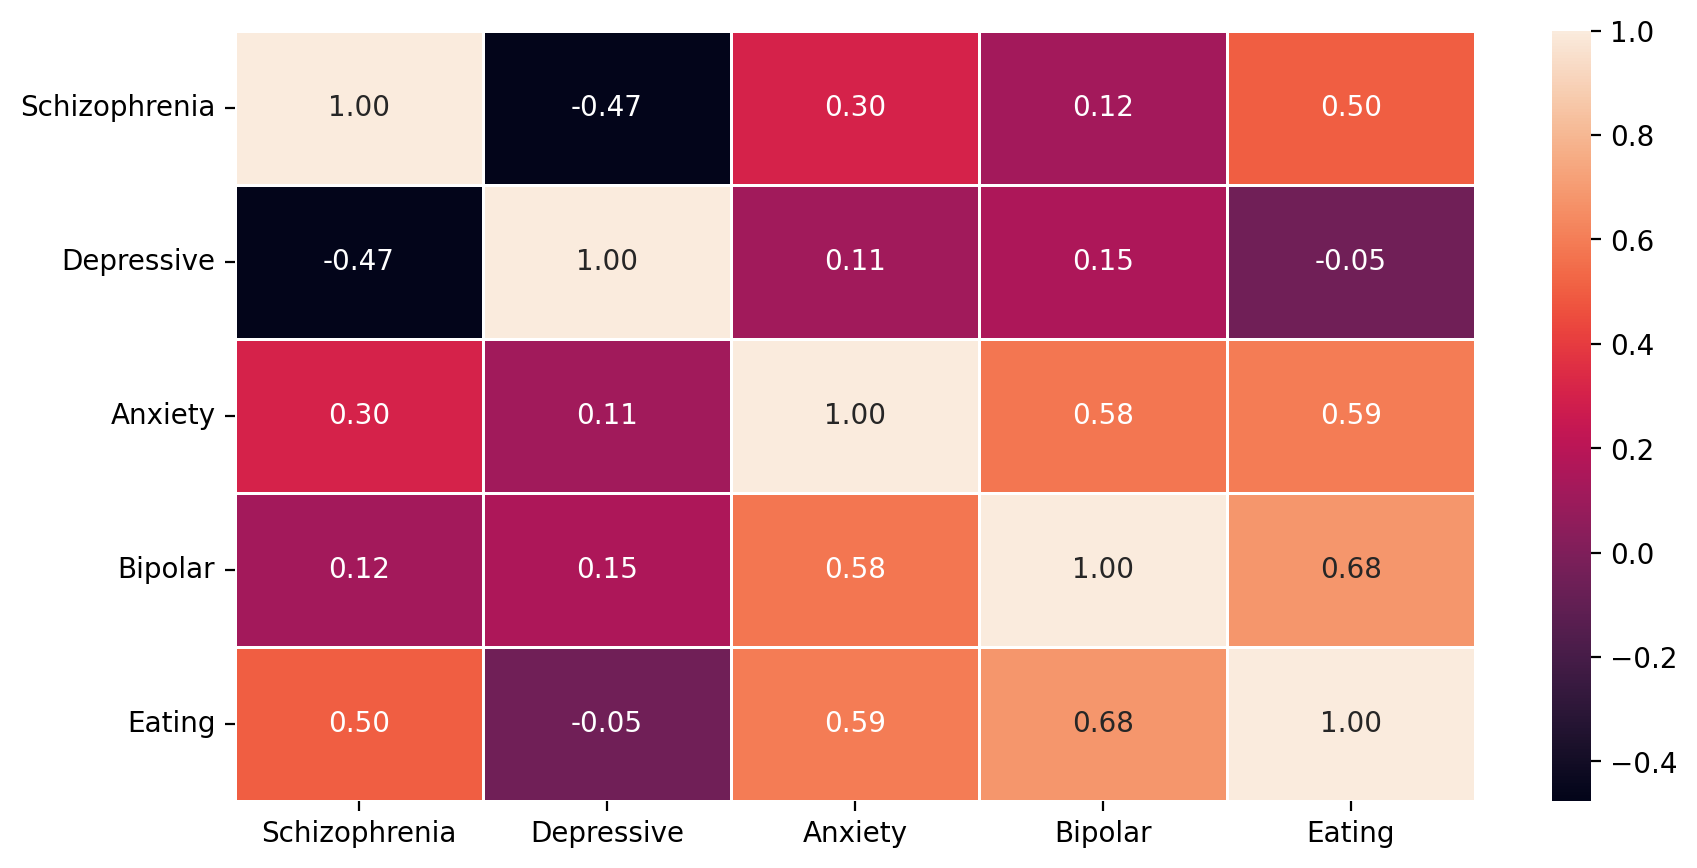

In [150]:
Corrmat = df[Numerical].corr()
plt.figure(figsize=(10, 5), dpi=200)
sns.heatmap(Corrmat, annot=True,fmt=".2f", linewidth=.5)

In [152]:
def plot_data(points, labels, title):   
    fig = plt.figure()
    if points.shape[1] > 2:    
        ax = fig.add_subplot(projection='3d')
        ax.scatter(points[:,0], points[:,1], points[:,2], c=labels, cmap='viridis')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(title)
    else:    
        plt.scatter(points[:,0], points[:,1], c=labels, cmap='viridis')
        plt.xlabel('X')
        plt.ylabel('Y')    
        plt.title(title)

    plt.show()

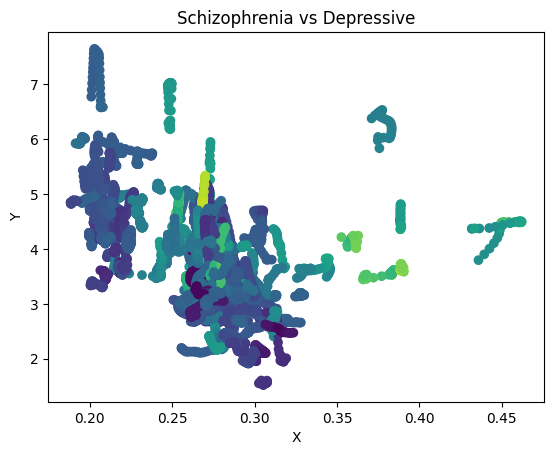

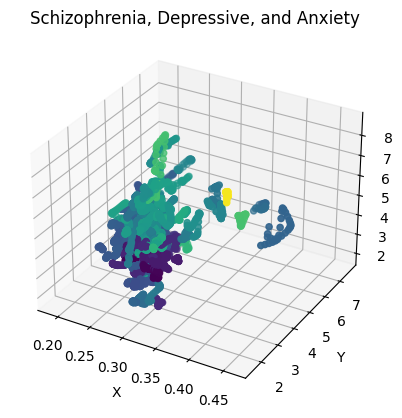

In [154]:
# Example usage for 2D plot (Schizophrenia vs Depressive)
points_2d = df[['Schizophrenia', 'Depressive']].values
labels_2d = df['Anxiety'].values
plot_data(points_2d, labels_2d, 'Schizophrenia vs Depressive')

# Example usage for 3D plot (Schizophrenia, Depressive, Anxiety)
points_3d = df[['Schizophrenia', 'Depressive', 'Anxiety']].values
labels_3d = df['Bipolar'].values
plot_data(points_3d, labels_3d, 'Schizophrenia, Depressive, and Anxiety')

K-Means

----- K-means -----


C:\Users\kinar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Labels:  [7 7 7 ... 1 1 4]
Centers:  [[0.23646298 6.13520069 4.21026966]
 [0.23869917 4.10869693 3.34377907]
 [0.28374945 3.38878564 5.52779454]
 [0.22291376 4.89383624 3.51568413]
 [0.28626157 2.7034072  3.39242057]
 [0.28343044 3.0705342  4.08939721]
 [0.26854685 3.91515213 4.45265333]
 [0.26842035 4.76085799 5.02528722]
 [0.26564816 3.22334571 2.33727996]
 [0.30691323 4.05807615 6.99843486]]


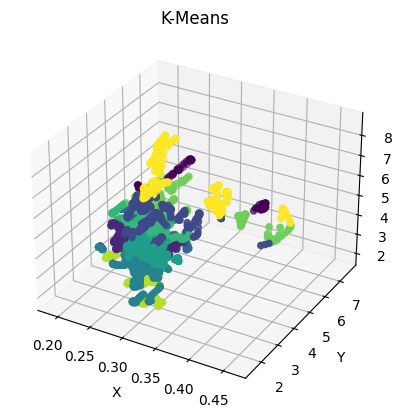

In [158]:
print('----- K-means -----')

points = df[['Schizophrenia', 'Depressive', 'Anxiety']].values

kmeans = KMeans(n_clusters=10).fit(points)
clustering_labels = kmeans.labels_
centers = kmeans.cluster_centers_

print('Labels: ', clustering_labels)
print('Centers: ', centers)

plot_data(points, clustering_labels, 'K-Means')

C:\Users\kinar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kinar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kinar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kinar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kinar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of

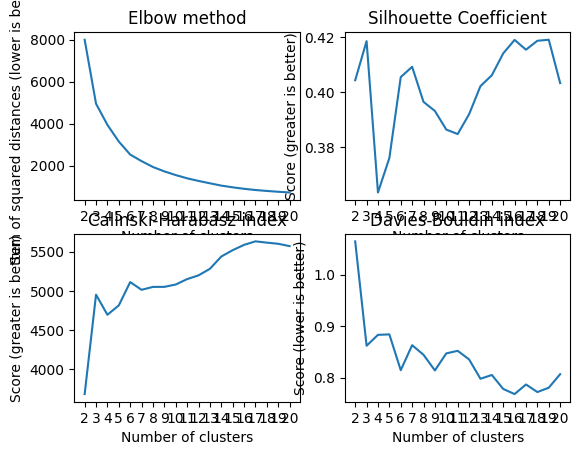

In [160]:
# Optimal number of clusters
sum_of_squared_distances = []
sscore = []
chscore = []
dbscore = []

ks = np.arange(2, 21)
for k in ks:
    # Find clustering model
    kmeans = KMeans(n_clusters=k).fit(points)

    # Evaluate sum of squared distances
    sum_of_squared_distances.append(kmeans.inertia_)

    # Evaluate Silhouette score
    sscore.append(silhouette_score(points, kmeans.labels_))

    # Evaluate Calinski-Harabasz index
    chscore.append(calinski_harabasz_score(points, kmeans.labels_))

    # Evaluate Davies-Bouldin index
    dbscore.append(davies_bouldin_score(points, kmeans.labels_))

fig, axs = plt.subplots(2, 2)

axs[0][0].plot(ks, sum_of_squared_distances)
axs[0][0].set_xlabel('Number of clusters')
axs[0][0].set_ylabel('Sum of squared distances (lower is better)')    
axs[0][0].set_title('Elbow method')
axs[0][0].set_xticks(ks)

axs[0][1].plot(ks, sscore)
axs[0][1].set_xlabel('Number of clusters')
axs[0][1].set_ylabel('Score (greater is better)')    
axs[0][1].set_title('Silhouette Coefficient')    
axs[0][1].set_xticks(ks)

axs[1][0].plot(ks, chscore)
axs[1][0].set_xlabel('Number of clusters')
axs[1][0].set_ylabel('Score (greater is better)')    
axs[1][0].set_title('Calinski-Harabasz index')    
axs[1][0].set_xticks(ks)

axs[1][1].plot(ks, dbscore)
axs[1][1].set_xlabel('Number of clusters')
axs[1][1].set_ylabel('Score (lower is better)')    
axs[1][1].set_title('Davies-Bouldin index')    
axs[1][1].set_xticks(ks)

plt.show()

----- Dendrogram plot -----


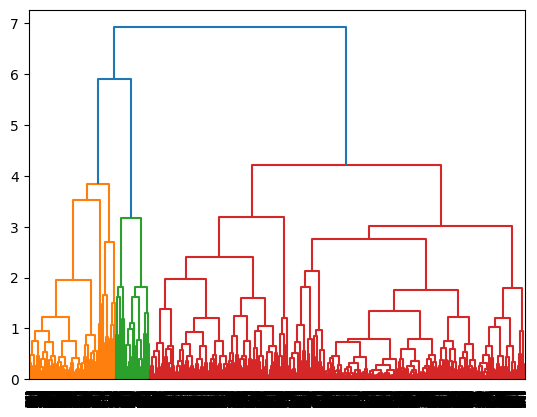

----- Aglomerative clustering -----
Labels:  [1 1 1 ... 2 2 2]


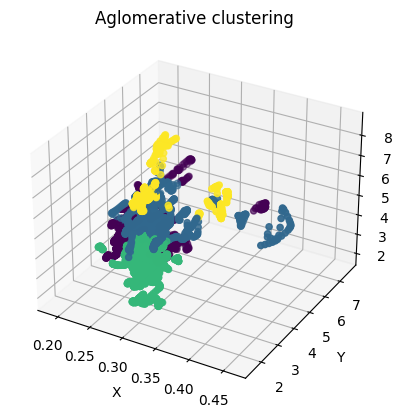

Labels:  [1 1 1 ... 1 1 1]


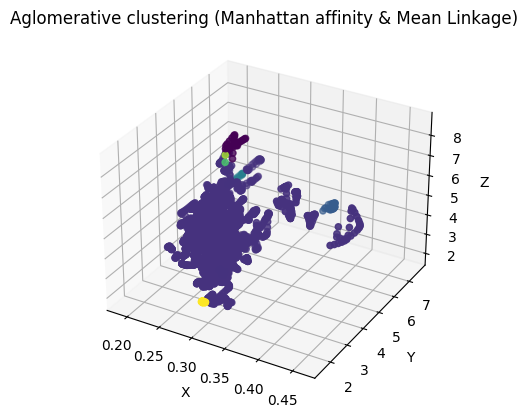

C:\Users\kinar\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



Labels:  [4 4 4 ... 1 1 1]


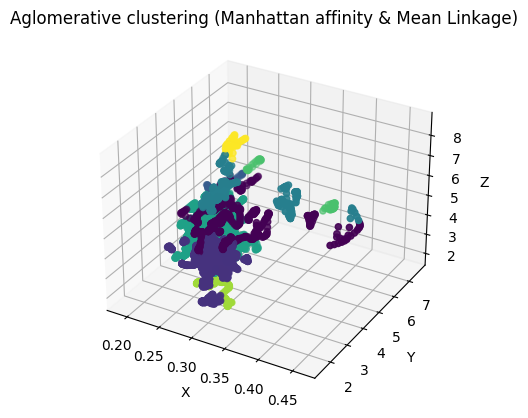

C:\Users\kinar\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



Labels:  [4 4 4 ... 1 1 1]


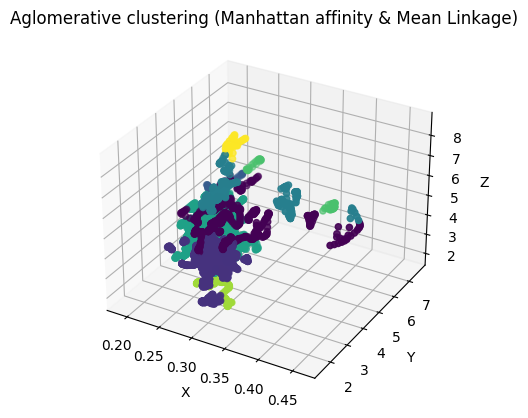

----- OPTICS -----
Labels:  [ 0  0  0 ... 28 28 28]


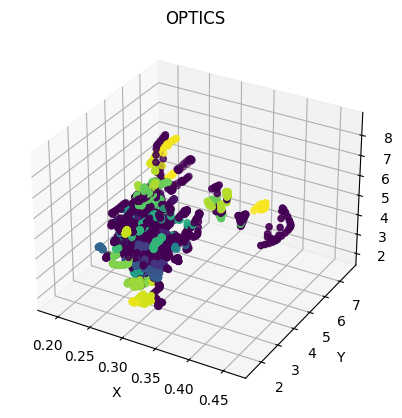

----- DBSCAN -----
Labels:  [0 0 0 ... 0 0 0]


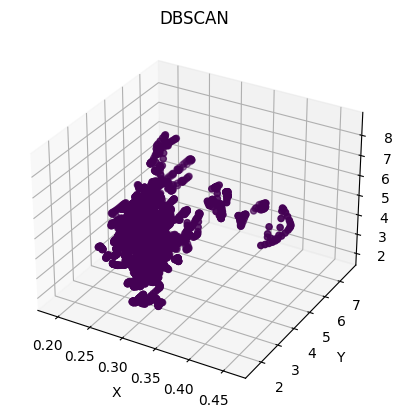

----- Spectral clustering -----
Labels:  [0 0 0 ... 0 0 0]


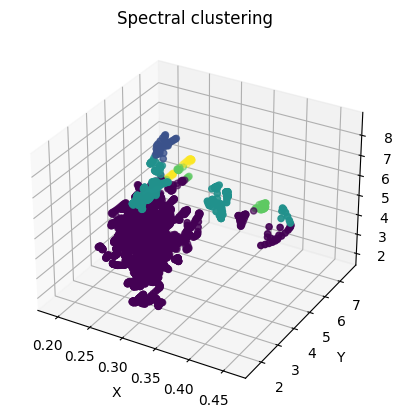

Labels:  [0 0 0 ... 0 0 0]


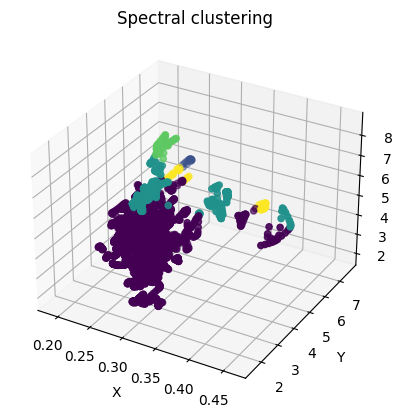

In [162]:
####### Dendrogram plot #######
print('----- Dendrogram plot -----')

linked = linkage(points, 'complete')
labelList = range(1, 11)

plt.figure()
dendrogram(linked, orientation='top',distance_sort='descending', show_leaf_counts=True)
plt.show()

####### Aglomerative clustering #######
print('----- Aglomerative clustering -----')
agl = AgglomerativeClustering(n_clusters=4).fit(points)
clustering_labels = agl.labels_
print('Labels: ', clustering_labels)
plot_data(points, clustering_labels, 'Aglomerative clustering')

# Aglomerative clustering with single linkage
agl = AgglomerativeClustering(n_clusters=8, linkage = 'single').fit(points)
clustering_labels = agl.labels_
print('Labels: ', clustering_labels)
plot_data(points, clustering_labels, 'Aglomerative clustering (Manhattan affinity & Mean Linkage)')

# Aglomerative clustering with manhattan distance and mean linkage
agl = AgglomerativeClustering(n_clusters=8, linkage = 'average', affinity = 'manhattan').fit(points)
clustering_labels = agl.labels_
print('Labels: ', clustering_labels)
plot_data(points, clustering_labels, 'Aglomerative clustering (Manhattan affinity & Mean Linkage)')

# Using custom distance matrix
dist = pairwise_distances(points, metric = 'l1')
agl = AgglomerativeClustering(n_clusters=8, linkage = 'average', affinity = 'precomputed').fit(dist)
clustering_labels = agl.labels_
print('Labels: ', clustering_labels)
plot_data(points, clustering_labels, 'Aglomerative clustering (Manhattan affinity & Mean Linkage)')

####### OPTICS #######
print('----- OPTICS -----')
optics = OPTICS(min_samples = 20).fit(points)
clustering_labels = optics.labels_
print('Labels: ', clustering_labels)
plot_data(points, clustering_labels, 'OPTICS')

####### DBSCAN #######
print('----- DBSCAN -----')
dbscan = DBSCAN(eps=1.5).fit(points)
clustering_labels = dbscan.labels_
print('Labels: ', clustering_labels)
plot_data(points, clustering_labels, 'DBSCAN')

####### Spectral clustering #######
print('----- Spectral clustering -----')
spectral = SpectralClustering(n_clusters=5).fit(points)
clustering_labels = spectral.labels_
print('Labels: ', clustering_labels)
plot_data(points, clustering_labels, 'Spectral clustering')

# Using custom affinity matrix
dist = pairwise_distances(points, metric = 'manhattan')
similarity = np.exp(- dist ** 2)

spectral = SpectralClustering(n_clusters=5, affinity = 'precomputed').fit(similarity)
clustering_labels = spectral.labels_
print('Labels: ', clustering_labels)
plot_data(points, clustering_labels, 'Spectral clustering')